## ShoplikelihoodV4 Model

In [1]:
!pip install xgboost lightgbm shap

In [43]:
!pip install catboost>=1.2

In [2]:
import logging
import sys
import os
from google.cloud import bigquery
from pyarrow import parquet
import gcsfs
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve

import json
import numpy as np
from joblib import dump
import time
from functools import partial
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier, early_stopping
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import shap
from scipy.special import expit  # Sigmoid function
from datetime import datetime

### Functions

In [3]:
# Set up logging configuration
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.StreamHandler(sys.stdout)
    ]
)


logger = logging.getLogger(__name__)

In [91]:
def load_from_bigquery(query, bq_client):
    return bq_client.query(query).to_dataframe()


def load_reco_reference_df(bq_client):
    print("Loading deal week reference table...")
    query = """ 
    SELECT 
        start_date, 
        end_date, 
        deal_yr, 
        deal_wk,
        CONCAT(CAST(deal_yr AS STRING), '_3', LPAD(CAST(deal_wk AS STRING), 2, '0')) AS week_identifier,
        deal_season_num
    from `dp-lore.loyalty_reco.prd_slpv3_date_ref` 
    """
    return load_from_bigquery(query=query, bq_client=bq_client)

def rename_pivot_columns(pivoted_df, reco_reference_pd, current_week_identifier, suffix:str, removal_cols:list=None):
    logger.info(f"Renaming pivoted columns with suffix '{suffix}'")
    col_reference = {}
    current_start_datetime = reco_reference_pd[reco_reference_pd["week_identifier"] == current_week_identifier].start_date.iloc[0]
    pivoted_cols = pivoted_df.columns
    if removal_cols:
        pivoted_cols = pivoted_df.columns.drop(removal_cols)

    for col in pivoted_cols:
        ref_start_datetime = reco_reference_pd[reco_reference_pd["week_identifier"] == col].start_date.iloc[0]
        delta = current_start_datetime - ref_start_datetime
        weeks_back = delta.days/7
        num_weeks_back = str(int(weeks_back))+suffix

        col_reference[col] = num_weeks_back

    # Rename columns based on the mapping    
    pivoted_df.rename(columns=col_reference, inplace=True)
    pivoted_df = pivoted_df.drop(columns=[f'0{suffix}'], errors='ignore')
    logger.info(f"renamed columns: {[pivoted_df.columns]}")
    return pivoted_df

def evaluate_classifier(model, model_name, X_train, X_val, X_test, y_train, y_val, y_test):
    """Train and evaluate a classifier with comprehensive metrics."""
    logger.info(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)
    
    # Evaluate on validation set
    val_predictions = model.predict(X_val)
    val_prob_predictions = model.predict_proba(X_val)[:, 1]
    
    print(f"\n{model_name} Validation Set Metrics:")
    print(classification_report(y_val, val_predictions))
    print(f"Validation AUC-ROC: {roc_auc_score(y_val, val_prob_predictions):.4f}")
    
    # Evaluate on test set
    test_predictions = model.predict(X_test)
    test_prob_predictions = model.predict_proba(X_test)[:, 1]
    
    print(f"\n{model_name} Test Set Metrics:")
    print(classification_report(y_test, test_predictions))
    print(f"Test AUC-ROC: {roc_auc_score(y_test, test_prob_predictions):.4f}")
    
    return {
        'model': model,
        'val_auc': roc_auc_score(y_val, val_prob_predictions),
        'test_auc': roc_auc_score(y_test, test_prob_predictions),
        'val_predictions': val_predictions,
        'test_predictions': pd.Series(test_predictions, index=y_test.index),
        'val_probabilities': val_prob_predictions,
        'test_probabilities':  pd.Series(test_prob_predictions, index=y_test.index),
        'results_table': pd.DataFrame({
            'actual': y_test,
            'predicted': test_predictions,
            'predicted_proba': test_prob_predictions
        }, index=y_test.index)
    }

def shap_analysis(model, model_name, X_train_scaled, X_val_scaled, feature_cols):
    """Perform SHAP value analysis for a given model and log results."""
    logger.info(f"\nPerforming SHAP analysis for {model_name}...")

    # Use a randomized subset of the validation data for SHAP analysis
    shap_sample_size = 10000
    if len(X_val_scaled) > shap_sample_size:
        random_indices = np.random.choice(len(X_val_scaled), shap_sample_size, replace=False)
        X_val_sample = X_val_scaled[random_indices]
    else:
        X_val_sample = X_val_scaled

    # Check if the model supports SHAP
    if hasattr(model, "predict_proba") or hasattr(model, "predict"):
        try:
            # Use TreeExplainer for tree-based models
            if model_name in ["randomforest", "xgboost", "lightgbm", 'catboost']:
                explainer = shap.TreeExplainer(model, model_output="raw")  # Use raw output
                shap_values_raw = explainer.shap_values(X_val_sample)

                # Convert raw SHAP values to probabilities
                base_value = explainer.expected_value  # Base value (log-odds)
                shap_values_class_1 = expit(base_value + shap_values_raw)  # Convert to probabilities for class 1
                shap_values_class_0 = 1 - shap_values_class_1  # Probabilities for class 0

                # SHAP summary for class 1 (positive class)
                logger.info(f"SHAP summary for class 1 (positive class):")
                shap_summary_class_1 = np.mean(np.abs(shap_values_class_1), axis=0)
                shap_summary_df_1 = pd.DataFrame({
                    "feature": feature_cols,
                    "mean_abs_shap_value": shap_summary_class_1
                }).sort_values("mean_abs_shap_value", ascending=False)
                logger.info("\n" + str(shap_summary_df_1.head(20)))  # Log top 20 features


                # SHAP summary for class 0 (negative class)
                logger.info(f"SHAP summary for class 0 (negative class):")
                shap_summary_class_0 = np.mean(np.abs(shap_values_class_0), axis=0)
                shap_summary_df_0 = pd.DataFrame({
                    "feature": feature_cols,
                    "mean_abs_shap_value": shap_summary_class_0
                }).sort_values("mean_abs_shap_value", ascending=False)
                logger.info("\n" + str(shap_summary_df_0.head(20)))  # Log top 20 features

                return shap_summary_df_1, shap_summary_df_0

            else:
                logger.info(f"SHAP analysis not implemented for model type: {model_name}")
                logger.info("Skipping SHAP analysis.")

            logger.info(f"SHAP analysis completed for {model_name}.")
        except Exception as e:
            logger.error(f"Error during SHAP analysis for {model_name}: {str(e)}")
    else:
        logger.info(f"SHAP analysis not supported for {model_name}.")


#### Load Datasets

In [5]:
PROJECT_PREFIX = 'it_'
CURRENT_WEEK_NUMBER = '2025_339'
WEEK_NUMBER = '2025_335'
TARGET_WEEK_NUMBER = '2025_337'
current_week_identifier = CURRENT_WEEK_NUMBER
week_identifier = WEEK_NUMBER
target_week_identifier = TARGET_WEEK_NUMBER


In [6]:
predictions_output_table = f"shoplikelihood_v4.{PROJECT_PREFIX}shoplikelihood_test_predictions_{CURRENT_WEEK_NUMBER}"
model_performance_output_table = f"shoplikelihood_v4.{PROJECT_PREFIX}shoplikelihood_test_model_performance"

customer_purchase_labels_path = f"gs://shoplikelihood_v4/ctr/{PROJECT_PREFIX}/input_data/{CURRENT_WEEK_NUMBER}/shoplikelihood_v4_customer_purchase_labels_ctr_{TARGET_WEEK_NUMBER}"
model_output_path = f"gs://shoplikelihood_v4/ctr/{PROJECT_PREFIX}/model_registry/{CURRENT_WEEK_NUMBER}/0/output/model/"
model_features_path = f"gs://shoplikelihood_v4/ctr/{PROJECT_PREFIX}/feature_store/{CURRENT_WEEK_NUMBER}/0/output/features"
gcs_embeddings_output_path = f"gs://shoplikelihood_v4/ctr/{PROJECT_PREFIX}/input_data/{CURRENT_WEEK_NUMBER}/shoplikelihood_v4_customer_embeddings_ctr_{WEEK_NUMBER}"
customer_purchase_profile_path = f"gs://shoplikelihood_v4/ctr/{PROJECT_PREFIX}/input_data/{CURRENT_WEEK_NUMBER}/shoplikelihood_v4_customer_purchase_profile_ctr_{WEEK_NUMBER}"
customer_purchase_history_path = f"gs://shoplikelihood_v4/ctr/{PROJECT_PREFIX}/input_data/{CURRENT_WEEK_NUMBER}/shoplikelihood_v4_customer_purchase_history_ctr_{WEEK_NUMBER}"
customer_point_profile_path = f"gs://shoplikelihood_v4/ctr/{PROJECT_PREFIX}/input_data/{CURRENT_WEEK_NUMBER}/shoplikelihood_v4_customer_point_profile_ctr_{WEEK_NUMBER}" 
npp_history_path = f"gs://shoplikelihood_v4/ctr/{PROJECT_PREFIX}/input_data/{CURRENT_WEEK_NUMBER}/shoplikelihood_v4_npp_history_ctr"
statistic_features_path = f"gs://shoplikelihood_v4/ctr/{PROJECT_PREFIX}/input_data/{CURRENT_WEEK_NUMBER}/shoplikelihood_v4_statistic_features_ctr_{WEEK_NUMBER}"


In [7]:
bq_project = 'dp-lore'
bq_client = bigquery.Client(project=bq_project)
fs               = gcsfs.GCSFileSystem()




In [8]:
reco_reference_pd = load_reco_reference_df(bq_client=bq_client)

Loading deal week reference table...


/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2438: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2452: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/google/cloud/bigquery/table.py:2466: UserWarning: Unable to represent RANGE schema as struct using pandas ArrowDtype. Using `object` instead. To use ArrowDtype, use pandas >= 1.5 and pyarrow >= 10.0.1.
  warnings.warn(_RANGE_PYARROW_WARNING)


In [9]:
# Customer purchase labels
logger.info(f"Loading customer purchase labels from: {customer_purchase_labels_path}")
customer_purchase_labels = [_path for _path in fs.glob(os.path.join(customer_purchase_labels_path, "*.parquet"))]
customer_labels_ds       = parquet.ParquetDataset(customer_purchase_labels, filesystem=fs)
customer_labels_pd_df    = customer_labels_ds.read().to_pandas()
logger.info(f"Loaded {len(customer_labels_pd_df)} customer purchase labels.")

2025-10-21 21:24:59,273 - INFO - Loading customer purchase labels from: gs://shoplikelihood_v4/ctr/it_/input_data/2025_339/shoplikelihood_v4_customer_purchase_labels_ctr_2025_337
2025-10-21 21:25:48,687 - INFO - Loaded 1268506 customer purchase labels.


In [10]:
# Embedding mapping table
logger.info(f"Loading LightFM embeddings from: {gcs_embeddings_output_path}")
embeddings_files = [_path for _path in fs.glob(os.path.join(gcs_embeddings_output_path, "*.parquet"))]
embedding_ds = parquet.ParquetDataset(embeddings_files, filesystem=fs)
embedding_df = embedding_ds.read().to_pandas()
logger.info(f"Total embedding rows loaded: {len(embedding_df)}")
logger.info(f"Embedding columns: {embedding_df.columns}")

2025-10-21 21:25:48,693 - INFO - Loading LightFM embeddings from: gs://shoplikelihood_v4/ctr/it_/input_data/2025_339/shoplikelihood_v4_customer_embeddings_ctr_2025_335
2025-10-21 21:36:27,791 - INFO - Total embedding rows loaded: 15452048
2025-10-21 21:36:27,792 - INFO - Embedding columns: Index(['latent_0', 'latent_1', 'latent_2', 'latent_3', 'latent_4', 'latent_5',
       'latent_6', 'latent_7', 'latent_8', 'latent_9',
       ...
       'latent_193', 'latent_194', 'latent_195', 'latent_196', 'latent_197',
       'latent_198', 'latent_199', 'lightfm_id', 'user_id', 'epsilon_id'],
      dtype='object', length=203)


In [11]:
#Customer Purchase Profile data
logger.info(f"Loading customer purchase profile data from: {customer_purchase_profile_path}")
customer_purchase_profile = [_path for _path in fs.glob(os.path.join(customer_purchase_profile_path, "*.parquet"))]
customer_purchase_profile_ds = parquet.ParquetDataset(customer_purchase_profile, filesystem=fs)
customer_purchase_profile_pd_df = customer_purchase_profile_ds.read().to_pandas()
logger.info(f"Purchase profile columns: {customer_purchase_profile_pd_df.columns}")
logger.info(f"Loaded {len(customer_purchase_profile_pd_df)} customer purchase profiles.")
customer_purchase_profile_pd_df = customer_purchase_profile_pd_df[customer_purchase_profile_pd_df['banner'] == 'CTR']   
customer_purchase_profile_pd_df.drop(["epcl_profileid", "banner"], axis=1, inplace=True, errors='ignore')
fillna_median_cols = ["days_since_last_purchase_p25", "days_since_last_purchase_p50", "days_since_last_purchase_p75", 
                       "avg_days_since_last_purchase", "stddev_days_since_last_purchase"]
customer_purchase_profile_pd_df[fillna_median_cols] = customer_purchase_profile_pd_df[fillna_median_cols].fillna(customer_purchase_profile_pd_df[fillna_median_cols].median())


2025-10-21 21:36:27,801 - INFO - Loading customer purchase profile data from: gs://shoplikelihood_v4/ctr/it_/input_data/2025_339/shoplikelihood_v4_customer_purchase_profile_ctr_2025_335
2025-10-21 21:37:42,836 - INFO - Purchase profile columns: Index(['banner', 'total_purchases', 'first_purchase_date',
       'last_purchase_date', 'days_since_last_purchase_p25',
       'days_since_last_purchase_p50', 'days_since_last_purchase_p75',
       'avg_days_since_last_purchase', 'stddev_days_since_last_purchase',
       'num_of_purchases_last_30_days', 'sales_last_30_days',
       'num_of_purchases_last_60_days', 'sales_last_60_days',
       'num_of_purchases_last_90_days', 'sales_last_90_days',
       'num_of_purchases_last_120_days', 'sales_last_120_days',
       'num_of_purchases_last_365_days', 'sales_last_365_days',
       'days_since_first_purchase', 'days_since_last_purchase',
       'epcl_profileid', 'epsilon_id'],
      dtype='object')
2025-10-21 21:37:42,838 - INFO - Loaded 12337552 c

In [12]:
# Customer Purchase History data
logger.info(f"Loading customer purchase history data from: {customer_purchase_history_path}")
customer_purchase_history = [_path for _path in fs.glob(os.path.join(customer_purchase_history_path, "*.parquet"))]
customer_history_ds = parquet.ParquetDataset(customer_purchase_history, filesystem=fs)
customer_history_pd_df = customer_history_ds.read().to_pandas()
customer_history_pd_df = customer_history_pd_df[customer_history_pd_df['banner'] == 'CTR']
customer_history_pd_df.drop(["epcl_profileid", "banner", week_identifier], axis=1, inplace=True, errors='ignore')
logger.info(f"Loaded {len(customer_history_pd_df)} customer purchase histories.")
customer_history_pivoted_df = customer_history_pd_df.pivot_table(
                                        index='epsilon_id',
                                        columns='week_identifier',
                                        values='made_purchase',
                                        aggfunc='max'  # or 'sum' if multiple purchases should be counted
                                    )\
                            .reset_index() \
                            .fillna(0.0)
customer_history_final_df = rename_pivot_columns(customer_history_pivoted_df, 
                                                 reco_reference_pd, 
                                                 week_identifier,
                                                 "_weeks_back_purchase", 
                                                 removal_cols=["epsilon_id"])


2025-10-21 21:37:52,262 - INFO - Loading customer purchase history data from: gs://shoplikelihood_v4/ctr/it_/input_data/2025_339/shoplikelihood_v4_customer_purchase_history_ctr_2025_335
2025-10-21 21:39:45,622 - INFO - Loaded 137075399 customer purchase histories.
2025-10-21 21:42:49,647 - INFO - Renaming pivoted columns with suffix '_weeks_back_purchase'
2025-10-21 21:42:54,279 - INFO - renamed columns: [Index(['epsilon_id', '104_weeks_back_purchase', '103_weeks_back_purchase',
       '102_weeks_back_purchase', '101_weeks_back_purchase',
       '100_weeks_back_purchase', '99_weeks_back_purchase',
       '98_weeks_back_purchase', '97_weeks_back_purchase',
       '96_weeks_back_purchase',
       ...
       '10_weeks_back_purchase', '9_weeks_back_purchase',
       '8_weeks_back_purchase', '7_weeks_back_purchase',
       '6_weeks_back_purchase', '5_weeks_back_purchase',
       '4_weeks_back_purchase', '3_weeks_back_purchase',
       '2_weeks_back_purchase', '1_weeks_back_purchase'],
     

In [13]:
#Customer Deal Season data
logger.info(f"Loading customer deal season data from bigquery table...")
last_year_week_identifier = str(int(week_identifier[0:4]) - 1) + week_identifier[4:]
reco_reference_filtered = reco_reference_pd[reco_reference_pd["week_identifier"] <= last_year_week_identifier]
customer_deal_season_pd_df = customer_history_pd_df.merge(reco_reference_pd, on='week_identifier', how='inner') \
                      .pivot_table(
                                        index='epsilon_id',
                                        columns='deal_season_num',
                                        values='made_purchase',
                                        aggfunc='max'
                                    )\
                            .reset_index() \
                            .fillna(0)

new_cols = []
for c in customer_deal_season_pd_df.columns:
    if c == "epsilon_id":
        new_cols.append(c)
    else:
        new_cols.append(f"deal_season_num_{int(c)}")
customer_deal_season_final_pd_df = customer_deal_season_pd_df.copy()
customer_deal_season_final_pd_df.columns = new_cols
logger.info(f"Loaded {len(customer_deal_season_final_pd_df)} customer deal season profiles.")


2025-10-21 21:42:54,294 - INFO - Loading customer deal season data from bigquery table...
2025-10-21 21:44:54,069 - INFO - Loaded 11069719 customer deal season profiles.


In [ ]:
# Customer Point Profile data
logger.info(f"Loading customer point profile data from: {customer_point_profile_path}")
customer_point_profile = [_path for _path in fs.glob(os.path.join(customer_point_profile_path, "*.parquet"))]
customer_point_profile_ds = parquet.ParquetDataset(customer_point_profile, filesystem=fs)
customer_point_profile_pd_df = customer_point_profile_ds.read().to_pandas()
customer_point_profile_pd_df = customer_point_profile_pd_df[customer_point_profile_pd_df['banner'] == 'CTR']
customer_point_profile_pd_df.drop("banner", axis=1, inplace=True, errors='ignore')
logger.info(f"Loaded {len(customer_point_profile_pd_df)} customer point profiles.")


customer_profile_summary_df = customer_point_profile_pd_df.merge(customer_purchase_profile_pd_df, on='epsilon_id', how='left')\
                                                          .merge(customer_history_final_df, on='epsilon_id', how='left') \
                                                          .merge(customer_deal_season_final_pd_df, on='epsilon_id', how='left')

customer_profile_summary_df.fillna(0, inplace=True)

2025-10-21 21:44:54,078 - INFO - Loading customer point profile data from: gs://shoplikelihood_v4/ctr/it_/input_data/2025_339/shoplikelihood_v4_customer_point_profile_ctr_2025_335


In [ ]:
# NPP data
logger.info(f"Loading NPP data from : {npp_history_path}")
npp_history = [_path for _path in fs.glob(os.path.join(npp_history_path, "*.parquet"))]
npp_history_ds = parquet.ParquetDataset(npp_history, filesystem=fs)
npp_history_pd_df = npp_history_ds.read().to_pandas()
logger.info(f"Loaded {len(npp_history_pd_df)} NPP history records.")
npp_history_pd_df = npp_history_pd_df[npp_history_pd_df["week_identifier"] <=week_identifier]
npp_history_pivoted_df = npp_history_pd_df.set_index('week_identifier')['npp_flag'].T.to_frame().T
npp_history_pivoted_df.reset_index(drop=True, inplace=True)
npp_history_pivoted_df = rename_pivot_columns(npp_history_pivoted_df, reco_reference_pd, week_identifier, "_weeks_back_NPP")
npp_history_pivoted_df = npp_history_pivoted_df.add_suffix('_npp_flag')

2025-10-21 21:48:54,537 - INFO - Loading NPP data from : gs://shoplikelihood_v4/ctr/it_/input_data/2025_339/shoplikelihood_v4_npp_history_ctr
2025-10-21 21:49:09,149 - INFO - Loaded 105 NPP history records.
2025-10-21 21:49:09,152 - INFO - Renaming pivoted columns with suffix '_weeks_back_NPP'
2025-10-21 21:49:09,235 - INFO - renamed columns: [Index(['53_weeks_back_NPP', '63_weeks_back_NPP', '84_weeks_back_NPP',
       '75_weeks_back_NPP', '44_weeks_back_NPP', '43_weeks_back_NPP',
       '27_weeks_back_NPP', '52_weeks_back_NPP', '35_weeks_back_NPP',
       '12_weeks_back_NPP', '11_weeks_back_NPP', '34_weeks_back_NPP',
       '30_weeks_back_NPP', '29_weeks_back_NPP', '33_weeks_back_NPP',
       '20_weeks_back_NPP', '77_weeks_back_NPP', '31_weeks_back_NPP',
       '51_weeks_back_NPP', '26_weeks_back_NPP', '25_weeks_back_NPP',
       '81_weeks_back_NPP', '66_weeks_back_NPP', '74_weeks_back_NPP',
       '62_weeks_back_NPP', '39_weeks_back_NPP', '82_weeks_back_NPP',
       '59_weeks_back_NP

### Combine data

In [ ]:
# Combine Model Features DataFrame
logger.info(embedding_df.columns.tolist())
logger.info(customer_profile_summary_df.columns.tolist())
model_features_df = embedding_df.merge(customer_profile_summary_df, on='epsilon_id', how='inner') \
                                .merge(npp_history_pivoted_df, how='cross') \
                                .merge(customer_labels_pd_df[['epsilon_id', 'purchase_flag']], on='epsilon_id', how='left') \
                                .drop_duplicates(subset='epsilon_id')

model_features_df["purchase_flag"] = model_features_df["purchase_flag"].fillna('N')


2025-10-21 21:49:09,243 - INFO - ['latent_0', 'latent_1', 'latent_2', 'latent_3', 'latent_4', 'latent_5', 'latent_6', 'latent_7', 'latent_8', 'latent_9', 'latent_10', 'latent_11', 'latent_12', 'latent_13', 'latent_14', 'latent_15', 'latent_16', 'latent_17', 'latent_18', 'latent_19', 'latent_20', 'latent_21', 'latent_22', 'latent_23', 'latent_24', 'latent_25', 'latent_26', 'latent_27', 'latent_28', 'latent_29', 'latent_30', 'latent_31', 'latent_32', 'latent_33', 'latent_34', 'latent_35', 'latent_36', 'latent_37', 'latent_38', 'latent_39', 'latent_40', 'latent_41', 'latent_42', 'latent_43', 'latent_44', 'latent_45', 'latent_46', 'latent_47', 'latent_48', 'latent_49', 'latent_50', 'latent_51', 'latent_52', 'latent_53', 'latent_54', 'latent_55', 'latent_56', 'latent_57', 'latent_58', 'latent_59', 'latent_60', 'latent_61', 'latent_62', 'latent_63', 'latent_64', 'latent_65', 'latent_66', 'latent_67', 'latent_68', 'latent_69', 'latent_70', 'latent_71', 'latent_72', 'latent_73', 'latent_74', '

In [62]:
model_features_df

,latent_0,latent_1,latent_2,latent_3,latent_4,latent_5,latent_6,latent_7,latent_8,latent_9,...,50_weeks_back_NPP_npp_flag,76_weeks_back_NPP_npp_flag,55_weeks_back_NPP_npp_flag,60_weeks_back_NPP_npp_flag,28_weeks_back_NPP_npp_flag,83_weeks_back_NPP_npp_flag,10_weeks_back_NPP_npp_flag,61_weeks_back_NPP_npp_flag,47_weeks_back_NPP_npp_flag,purchase_flag
0,-0.236511,0.367811,-0.264329,0.150110,0.043657,0.307158,0.085822,0.107835,0.282386,0.036304,...,0,0,1,0,0,0,0,1,0,Y
1,-0.018318,0.101403,0.147813,-0.130497,0.069839,0.157409,-0.186541,0.070797,0.075702,-0.314529,...,0,0,1,0,0,0,0,1,0,N
2,0.011333,-0.065377,-0.011443,-0.155225,-0.057911,0.101626,0.217250,0.081023,0.088014,-0.159569,...,0,0,1,0,0,0,0,1,0,N
3,-0.280515,0.574260,-0.148927,-0.099272,0.017459,0.039658,-0.030500,0.272102,0.311880,0.018663,...,0,0,1,0,0,0,0,1,0,N
4,-0.047318,-0.197533,0.383193,0.269007,0.173252,0.310919,-0.167641,-0.217669,-0.178382,-0.123584,...,0,0,1,0,0,0,0,1,0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10310432,0.183855,-0.105890,-0.177621,0.237863,0.006582,0.085435,0.257373,0.046415,-0.068825,-0.224214,...,0,0,1,0,0,0,0,1,0,N
10310433,0.146169,-0.204424,-0.142251,0.372205,0.142079,-0.140991,-0.168030,-0.197757,0.351957,-0.247374,...,0,0,1,0,0,0,0,1,0,N
10310434,0.140745,-0.600010,0.093211,-0.021007,0.288595,0.002239,0.017772,-0.123403,0.060214,-0.070999,...,0,0,1,0,0,0,0,1,0,N
10310435,0.116504,-0.120848,0.428490,0.149965,0.018149,-0.362648,-0.408379,-0.213171,0.311935,-0.075867,...,0,0,1,0,0,0,0,1,0,N


In [ ]:
logger.info(f"Model features shape: {model_features_df.shape}")
logger.info(model_features_df.head())
logger.info(model_features_df.groupby('purchase_flag').count())

2025-10-21 21:52:36,107 - INFO - Model features shape: (10078048, 450)
2025-10-21 21:52:36,109 - INFO -    latent_0  latent_1  latent_2  latent_3  latent_4  latent_5  latent_6  \
0 -0.236511  0.367811 -0.264329  0.150110  0.043657  0.307158  0.085822   
1 -0.018318  0.101403  0.147813 -0.130497  0.069839  0.157409 -0.186541   
2  0.011333 -0.065377 -0.011443 -0.155225 -0.057911  0.101626  0.217250   
3 -0.280515  0.574260 -0.148927 -0.099272  0.017459  0.039658 -0.030500   
4 -0.047318 -0.197533  0.383193  0.269007  0.173252  0.310919 -0.167641   

   latent_7  latent_8  latent_9  ...  50_weeks_back_NPP_npp_flag  \
0  0.107835  0.282386  0.036304  ...                           0   
1  0.070797  0.075702 -0.314529  ...                           0   
2  0.081023  0.088014 -0.159569  ...                           0   
3  0.272102  0.311880  0.018663  ...                           0   
4 -0.217669 -0.178382 -0.123584  ...                           0   

   76_weeks_back_NPP_npp_flag  55_we

### Feature Preprocessing

In [ ]:
# =============================================
# Prepare data for training
# =============================================
feature_cols = model_features_df.columns.drop(["epsilon_id", "epcl_profileid", "lightfm_id", "user_id", "purchase_flag", "enroll_date", "register_date", "first_purchase_date", "last_purchase_date"]).tolist()

# Prepare X (features) and y (target)
X = model_features_df[feature_cols]
y = (model_features_df['purchase_flag'] == 'Y').astype(int)  # Convert to binary

# Split data
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

# Detect binary and numeric columns
column_vals = ["weeks_back", "deal_season"]
binary_cols = []
for column in X_train.columns:
    if any (val in column for val in column_vals):
        binary_cols.append(column)

numeric_cols = [col for col in X_train.columns if col not in binary_cols]

In [ ]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_cols),
    ('bin', 'passthrough', binary_cols)
])

# Scale the training data
X_train_scaled = preprocessor.fit_transform(X_train)

# Scale validation and test data using the same parameters
X_val_scaled = preprocessor.transform(X_val)
X_test_scaled = preprocessor.transform(X_test)

logger.info(f"Training set size: {len(X_train)}")
logger.info(f"Validation set size: {len(X_val)}")
logger.info(f"Test set size: {len(X_test)}")

2025-10-21 21:57:07,069 - INFO - Training set size: 6046828
2025-10-21 21:57:07,070 - INFO - Validation set size: 2015610
2025-10-21 21:57:07,071 - INFO - Test set size: 2015610


2015610

In [ ]:
# Calculate class weight for XGBoost and LightGBM
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
logger.info(f"Class distribution in training set: {y_train.value_counts().to_dict()}")
logger.info(f"Scale pos weight for handling class imbalance: {scale_pos_weight}")


2025-10-21 21:57:07,133 - INFO - Class distribution in training set: {0: 5332935, 1: 713893}
2025-10-21 21:57:07,134 - INFO - Scale pos weight for handling class imbalance: 7.470216124825429


In [30]:
!cat /proc/meminfo | grep Mem

MemTotal:       247413804 kB
MemFree:        39734384 kB
MemAvailable:   39159956 kB


In [31]:
import psutil
psutil.virtual_memory()

svmem(total=253351735296, available=40099414016, percent=84.2, used=211320668160, free=40687296512, active=486109184, inactive=211293798400, buffers=82460672, cached=1261309952, shared=917504, slab=208625664)

In [32]:
%whos

Variable                           Type                 Data/Info
-----------------------------------------------------------------
CURRENT_WEEK_NUMBER                str                  2025_339
ColumnTransformer                  ABCMeta              <class 'sklearn.compose._<...>ormer.ColumnTransformer'>
LGBMClassifier                     type                 <class 'lightgbm.sklearn.LGBMClassifier'>
PROJECT_PREFIX                     str                  it_
StandardScaler                     type                 <class 'sklearn.preproces<...>ng._data.StandardScaler'>
TARGET_WEEK_NUMBER                 str                  2025_337
WEEK_NUMBER                        str                  2025_335
X                                  DataFrame                      latent_0  laten<...>78048 rows x 441 columns]
XGBClassifier                      type                 <class 'xgboost.sklearn.XGBClassifier'>
X_temp                             DataFrame                     latent_0  latent<.

In [39]:
import sys
try:
    import pandas as pd
except Exception:
    pd = None
try:
    import numpy as np
except Exception:
    np = None

def _sizeof(obj):
    try:
        if pd is not None and isinstance(obj, pd.DataFrame):
            return obj.memory_usage(deep=True).sum()
        if pd is not None and isinstance(obj, pd.Series):
            return obj.memory_usage(deep=True)
        if np is not None and isinstance(obj, np.ndarray):
            return obj.nbytes
        return sys.getsizeof(obj)
    except Exception:
        return 0

def show_top_vars(n=15, skip_private=True):
    # ✅ snapshot to avoid "dictionary changed size during iteration"
    snap = {k: globals()[k] for k in list(globals().keys())}
    rows = []
    for name, obj in snap.items():
        if skip_private and name.startswith('_'):
            continue
        size = _sizeof(obj)
        rows.append((name, type(obj).__name__, size))
    rows.sort(key=lambda x: x[2], reverse=True)
    for name, typ, size in rows[:n]:
        print(f"{name:30s} {typ:20s} {size/1024**2:10.2f} MB")

show_top_vars()

model_features_df              DataFrame              27987.03 MB
X                              DataFrame              22989.93 MB
X_train_scaled                 ndarray                20344.93 MB
X_temp                         DataFrame              18391.94 MB
X_train                        DataFrame              13793.96 MB
X_val_scaled                   ndarray                 6781.65 MB
X_test_scaled                  ndarray                 6781.65 MB
X_test                         DataFrame               4597.99 MB
X_val                          DataFrame               4597.99 MB
customer_purchase_profile_pd_df DataFrame               4176.93 MB
customer_deal_season_pd_df     DataFrame               1530.75 MB
customer_deal_season_final_pd_df DataFrame               1530.75 MB
customer_labels_pd_df          DataFrame                362.92 MB
y                              Series                   153.78 MB
y_temp                         Series                   123.02 MB


In [21]:
# del customer_history_pd_df
# del customer_profile_summary_df
# del embedding_df                   
# del customer_history_pivoted_df    
# del customer_history_final_df 
# del customer_point_profile_pd_df   
del customer_purchase_profile_pd_df
del customer_deal_season_pd_df     
del customer_deal_season_final_pd_df

### Modelling

In [22]:
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [23]:
# Initialize all models

default_params = {
    "n_estimators":500,
    "max_depth":8,
    "learning_rate":0.05,
    "subsample":0.8,
    "colsample_bytree":0.8,
    "scale_pos_weight":scale_pos_weight,
    "tree_method":'hist',
    "n_jobs":-1,
    "random_state":42
    }   
best_params = default_params

models = {
    'xgboost': XGBClassifier(**best_params
    ),
    'lightgbm': LGBMClassifier(
        n_estimators=500,
        max_depth=8,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_jobs=-1
    ),
    'catboost': CatBoostClassifier(
        iterations=500,
        depth=8,
        learning_rate=0.05,
        subsample=0.8,
        scale_pos_weight=scale_pos_weight,
        random_seed=42,
        verbose=0  # Suppress CatBoost logs
    ),

}


In [25]:
results = {}
for model_name, model in models.items():
    logger.info(f"\nEvaluating {model_name}...")
    results[model_name] = evaluate_classifier(
        model, model_name, 
        X_train_scaled, X_val_scaled, X_test_scaled, 
        y_train, y_val, y_test
    )


2025-10-21 22:20:06,260 - INFO - 
Evaluating xgboost...
2025-10-21 22:20:06,261 - INFO - 
Training xgboost...

xgboost Validation Set Metrics:
              precision    recall  f1-score   support

           0       0.95      0.70      0.81   1777645
           1       0.25      0.75      0.37    237965

    accuracy                           0.70   2015610
   macro avg       0.60      0.72      0.59   2015610
weighted avg       0.87      0.70      0.76   2015610

Validation AUC-ROC: 0.8017

xgboost Test Set Metrics:
              precision    recall  f1-score   support

           0       0.95      0.70      0.81   1777646
           1       0.25      0.75      0.38    237964

    accuracy                           0.71   2015610
   macro avg       0.60      0.73      0.59   2015610
weighted avg       0.87      0.71      0.76   2015610

Test AUC-ROC: 0.8027
2025-10-21 22:24:51,335 - INFO - 
Evaluating lightgbm...
2025-10-21 22:24:51,336 - INFO - 
Training lightgbm...
[LightGBM] [Info

/opt/conda/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



lightgbm Validation Set Metrics:
              precision    recall  f1-score   support

           0       0.96      0.69      0.80   1777645
           1       0.25      0.76      0.37    237965

    accuracy                           0.70   2015610
   macro avg       0.60      0.72      0.59   2015610
weighted avg       0.87      0.70      0.75   2015610

Validation AUC-ROC: 0.8014


/opt/conda/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/opt/conda/envs/tensorflow/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



lightgbm Test Set Metrics:
              precision    recall  f1-score   support

           0       0.96      0.69      0.80   1777646
           1       0.25      0.76      0.37    237964

    accuracy                           0.70   2015610
   macro avg       0.60      0.72      0.59   2015610
weighted avg       0.87      0.70      0.75   2015610

Test AUC-ROC: 0.8025
2025-10-21 22:27:46,824 - INFO - 
Evaluating catboost...
2025-10-21 22:27:46,825 - INFO - 
Training catboost...

catboost Validation Set Metrics:
              precision    recall  f1-score   support

           0       0.96      0.69      0.80   1777645
           1       0.25      0.76      0.37    237965

    accuracy                           0.70   2015610
   macro avg       0.60      0.73      0.59   2015610
weighted avg       0.87      0.70      0.75   2015610

Validation AUC-ROC: 0.8025

catboost Test Set Metrics:
              precision    recall  f1-score   support

           0       0.96      0.69      0.

### Model Selection

In [57]:
best_model_name = max(results.items(), key=lambda x: x[1]['val_auc'])[0]
model = models[best_model_name]
print(f"best model name: {best_model_name}")

best model name: catboost


In [72]:
results[best_model_name]['results_table']

,actual,predicted,predicted_proba
9370056,0,1,0.639301
2271090,0,0,0.263508
674182,0,1,0.536619
2943940,0,1,0.808269
2285230,0,1,0.623138
...,...,...,...
978776,0,1,0.686613
9293041,1,0,0.279727
3876180,0,0,0.028562
4766254,0,0,0.227240


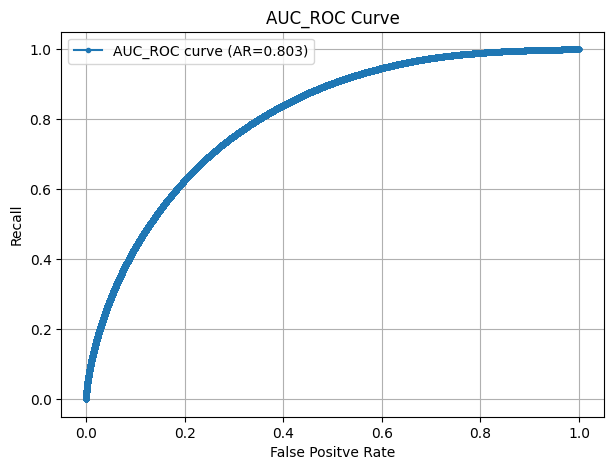

In [100]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

# Extract columns
y_true = results[best_model_name]['results_table']["actual"]
y_score = results[best_model_name]['results_table']["predicted_proba"]
y_pred = results[best_model_name]['results_table']["predicted"]

# Compute precision, recall, thresholds
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# Compute area under the PR curve (average precision)
auc_roc = roc_auc_score(y_true, y_score)

# Plot the curve
plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, marker='.', label=f'AUC_ROC curve (AR={auc_roc:.3f})')
plt.xlabel("False Positve Rate")
plt.ylabel("Recall")
plt.title("AUC_ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

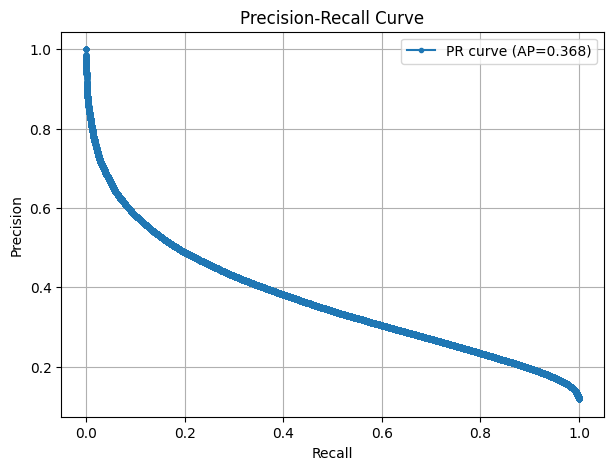

In [75]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

# Extract columns
y_true = results[best_model_name]['results_table']["actual"]
y_score = results[best_model_name]['results_table']["predicted_proba"]

# Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_score)

# Compute area under the PR curve (average precision)
avg_precision = average_precision_score(y_true, y_score)

# Plot the curve
plt.figure(figsize=(7,5))
plt.plot(recall, precision, marker='.', label=f'PR curve (AP={avg_precision:.3f})')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

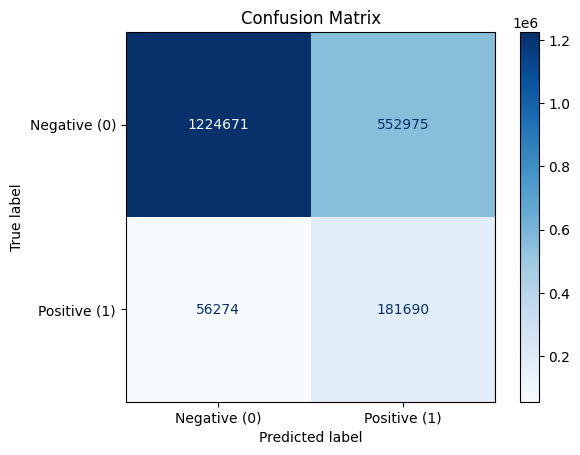

In [104]:
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative (0)", "Positive (1)"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.show()


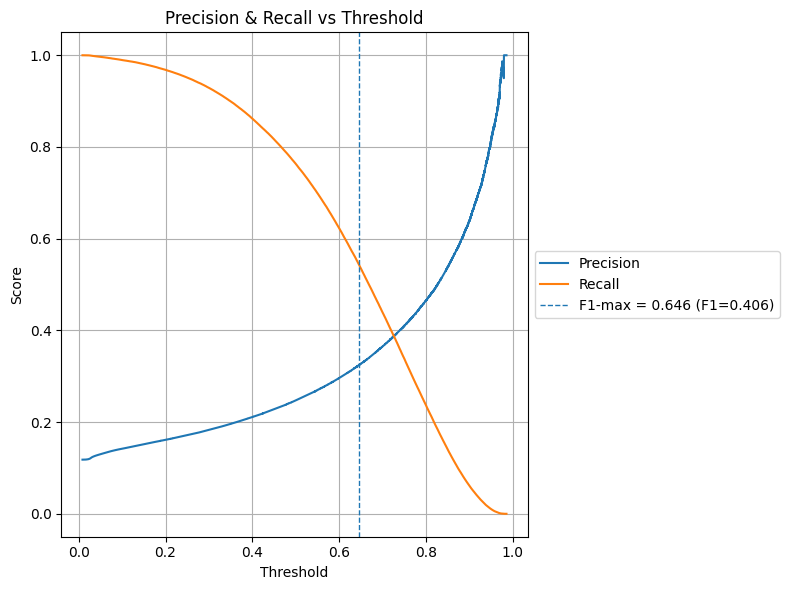

,threshold,precision,recall,f1,tp,fp,fn,tn
0,0.2,0.161357,0.968180,0.276613,230392,1197451,7572,580195
1,0.3,0.182847,0.928884,0.305548,221041,987843,16923,789803
2,0.4,0.211013,0.861895,0.339024,205100,766880,32864,1010766
3,0.5,0.247310,0.763519,0.373606,181690,552975,56274,1224671
4,0.6,0.295935,0.623447,0.401356,148358,352961,89606,1424685
5,0.7,0.364513,0.439970,0.398703,104697,182527,133267,1595119
6,0.8,0.464532,0.237687,0.314470,56561,65198,181403,1712448
7,0.9,0.637611,0.062093,0.113166,14776,8398,223188,1769248


In [97]:

# Extract columns
y_true = np.asarray(results[best_model_name]['results_table']["actual"], dtype=int)
y_score = np.asarray(results[best_model_name]['results_table']["predicted_proba"], dtype=float)

# PR vs threshold
prec, rec, thr = precision_recall_curve(y_true, y_score)           
prec, rec = prec[:-1], rec[:-1]   # align to thr

# F1 per threshold
with np.errstate(divide="ignore", invalid="ignore"):
    f1 = 2 * prec * rec / (prec + rec)
    f1 = np.nan_to_num(f1)

i_best = f1.argmax()
t_f1   = thr[i_best]
best_f1 = f1[i_best]

# Plot data
plt.figure(figsize=(8,6))
plt.plot(thr, prec, label="Precision")
plt.plot(thr, rec,  label="Recall")
plt.axvline(t_f1, ls="--", lw=1, label=f"F1-max = {t_f1:.3f} (F1={best_f1:.3f})")
plt.xlabel("Threshold"); plt.ylabel("Score"); plt.title("Precision & Recall vs Threshold")
plt.grid(True); plt.legend(loc="center left", bbox_to_anchor=(1,0.5)); plt.tight_layout()
plt.show()

# Threshold Detailed View
chosen = np.array([0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
Yhat   = (y_score[:, None] >= chosen).astype(int)         # shape (n_samples, n_thr)
pos    = (y_true[:, None] == 1)
neg    = ~pos

tp = (Yhat & pos).sum(axis=0)
fp = (Yhat & neg).sum(axis=0)
fn = ((1 - Yhat) & pos).sum(axis=0)
tn = ((1 - Yhat) & neg).sum(axis=0)

with np.errstate(divide="ignore", invalid="ignore"):
    p  = np.nan_to_num(tp / (tp + fp), nan=1.0)
    r  = np.nan_to_num(tp / (tp + fn), nan=0.0)
    f1c = np.nan_to_num(2 * p * r / (p + r))

out = pd.DataFrame({
    "threshold": chosen,
    "precision": p, "recall": r, "f1": f1c,
    "tp": tp, "fp": fp, "fn": fn, "tn": tn
}).sort_values("threshold")
display(out)

In [92]:
# Perform SHAP analysis for each model
shap_summary_1, shap_summary_0 = shap_analysis(model, best_model_name, X_train_scaled, X_val_scaled, feature_cols)

2025-10-22 00:02:01,385 - INFO - 
Performing SHAP analysis for catboost...
2025-10-22 00:02:06,838 - INFO - SHAP summary for class 1 (positive class):
2025-10-22 00:02:06,851 - INFO - 
                          feature  mean_abs_shap_value
313        35_weeks_back_purchase             0.479907
237            sales_last_90_days             0.479899
227  days_since_last_purchase_p25             0.479844
337        11_weeks_back_purchase             0.479771
308        40_weeks_back_purchase             0.479756
309        39_weeks_back_purchase             0.479697
261        87_weeks_back_purchase             0.479682
239           sales_last_120_days             0.479681
353             deal_season_num_6             0.479659
328        20_weeks_back_purchase             0.479657
257        91_weeks_back_purchase             0.479650
349             deal_season_num_2             0.479648
220     base_points_last_365_days             0.479647
321        27_weeks_back_purchase            

### Save data

In [87]:
_, sample_X, __, sample_y = train_test_split(X, y, test_size=0.02, random_state=42, stratify=y)
sample_df = sample_X
sample_df['purchase_flag'] = sample_y

In [88]:
len(sample_X), len(sample_y)

(201561, 201561)

In [89]:
del _
del __

In [90]:
sample_df.to_csv("data.csv", index=False)